In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import necessary modules from scikit-learn for pipline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [203]:
trainset = pd.read_csv('./Dataset/LoanPrediction_TrainSet.csv')
testset = pd.read_csv('./DataSet/LoanPrediction_TestSet.csv')

trainset = trainset.drop(columns=["Unnamed: 0"])
testset = testset.drop(columns=["Unnamed: 0"])

# Data Exploration:

In [204]:
trainset.head(10)

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


### Analytics Base Table ABT

In [205]:

ABT_train = trainset.describe(include="all").T

ABT_train = ABT_train.reset_index().rename(columns={'index': 'Feature'})
ABT_train['Missing'] = trainset.isnull().sum().values
ABT_train['dtype'] = trainset.dtypes.values
ABT_train.to_excel('ABT_train.xlsx', index=False)
ABT_train


# Wrong data types for some features like 'Dependents' and 'Credit_History' and missing values in some features
# There is some unbalance in the target variable 'Loan_Status' as i belive aswell som Bias in features for example Gender more male and females
# Dependents looks like it have some not allowed additions sign as well for 3+ as a category which i will fix


,Feature,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,dtype
0,LoanID,614,614,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
1,Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,object
2,Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,object
3,Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,object
4,Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
5,SelfEmployed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,object
6,ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0,0,int64
7,CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0,0,float64
8,LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0,22,float64
9,LoanAmountTerm,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0,14,float64


### Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

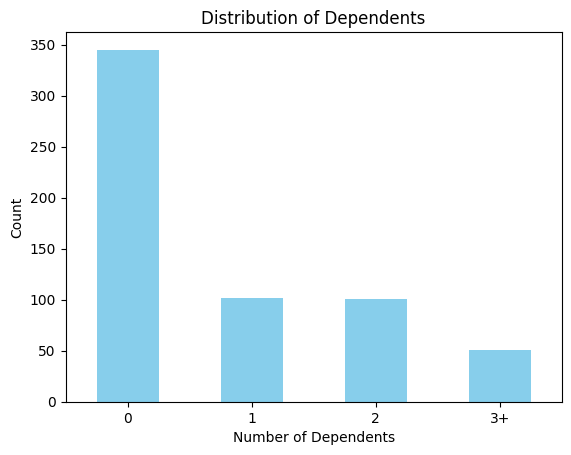

In [206]:
# Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

dependents_count = trainset['Dependents'].value_counts()
dependents_count.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')
plt.title('Distribution of Dependents')
plt.xticks(rotation=0)
plt.show()

In [207]:
# fix dependents
trainset['Dependents'] = trainset['Dependents'].replace('3+', 3).astype(float)
testset['Dependents'] = testset['Dependents'].replace('3+', 3).astype(float)


In [208]:
X_train = trainset.drop(columns=['LoanID', 'LoanStatus'])
y_train = trainset['LoanStatus'].map({'N':0, 'Y':1})
X_test = testset.drop(columns=['LoanID'])
y_test = testset['LoanStatus'].map({'N':0, 'Y':1})


In [209]:
num_select = make_column_selector(dtype_include=np.number)
cat_select = make_column_selector(dtype_include=object)

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_select),
    ('cat', cat_pipeline, cat_select)
])  

#investigate the preprocessed data
preprocess.fit(X_train)
X_train_processed = preprocess.transform(X_train)
feature = preprocess.get_feature_names_out()
X_train_proccessed = pd.DataFrame(X_train_processed, columns=feature)

X_train_proccessed



,num__Dependents,num__ApplicantIncome,num__CoapplicantIncome,num__LoanAmount,num__LoanAmountTerm,num__CreditHistory,cat__Gender_Female,cat__Gender_Male,cat__Married_No,cat__Married_Yes,cat__Education_Graduate,cat__Education_Not Graduate,cat__SelfEmployed_No,cat__SelfEmployed_Yes,cat__PropertyArea_Rural,cat__PropertyArea_Semiurban,cat__PropertyArea_Urban
0,-0.761490,0.072991,-0.554487,0.000000,0.279851,0.451640,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.236612,-0.134412,-0.038732,-0.219273,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.761490,-0.393747,-0.554487,-0.957641,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.761490,-0.462062,0.251980,-0.314547,0.279851,0.451640,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.761490,0.097728,-0.554487,-0.064454,0.279851,0.451640,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.761490,-0.410130,-0.554487,-0.898095,0.279851,0.451640,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
610,2.232816,-0.212557,-0.554487,-1.267279,-2.518655,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
611,0.236612,0.437174,-0.472404,1.269371,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
612,1.234714,0.357064,-0.554487,0.483367,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [210]:
#List top 5 (five) highly correlated variables with the target variable ‘LoanStatus’.
X_train_proccessed['LoanStatus'] = y_train.values
topcorr = X_train_proccessed.corr()['LoanStatus'].sort_values(ascending=False).head(6)
topcorr.to_excel('Top5_correlated_features.xlsx', index=True)
topcorr


LoanStatus                     1.000000
num__CreditHistory             0.540483
cat__PropertyArea_Semiurban    0.136540
cat__Married_Yes               0.091478
cat__Education_Graduate        0.085884
cat__Gender_Male               0.017987
Name: LoanStatus, dtype: float64

In [211]:
    """
LoanStatus                     1.000000
num__CreditHistory             0.540556
cat__PropertyArea_Semiurban    0.136540
cat__Married_Yes               0.091478
cat__Education_Graduate        0.085884
cat__Dependents_2              0.062384
Name: LoanStatus, dtype: float64
    """

'\nLoanStatus                     1.000000\nnum__CreditHistory             0.540556\ncat__PropertyArea_Semiurban    0.136540\ncat__Married_Yes               0.091478\ncat__Education_Graduate        0.085884\ncat__Dependents_2              0.062384\nName: LoanStatus, dtype: float64\n'

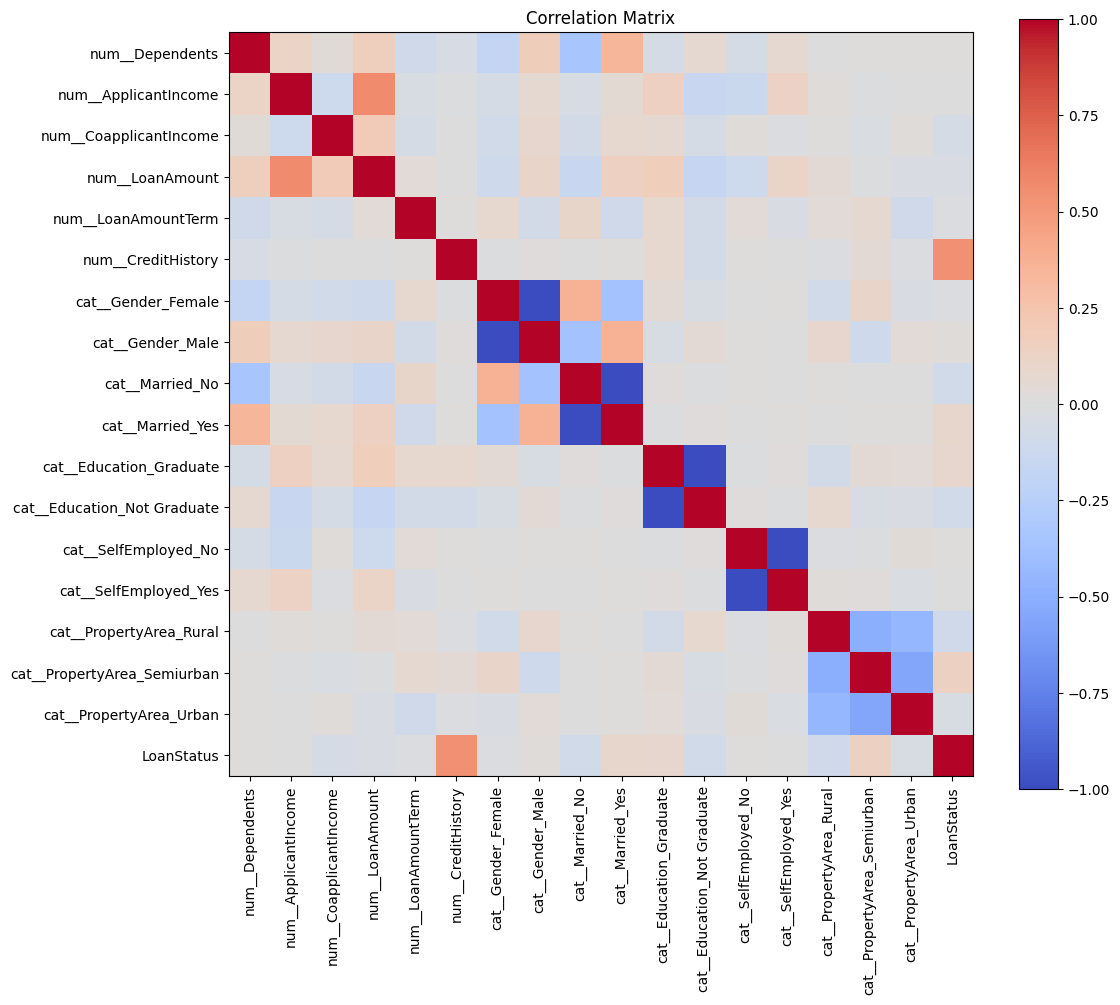

In [212]:
corr = X_train_proccessed.corr()
plt.figure(figsize=(12,10))
cor = X_train_proccessed.corr()
cmap = plt.get_cmap('coolwarm')
plt.imshow(cor, cmap, interpolation='none')
plt.colorbar()
plt.xticks(range(len(cor)), cor.columns, rotation=90)
plt.yticks(range(len(cor)), cor.columns)
plt.title('Correlation Matrix')
plt.show()


In [213]:
# Create a pipeline with preprocessing and a classifier
pipeline = make_pipeline(preprocess,LogisticRegression(max_iter=1000))   
pipeline.fit(X_train, y_train)
pipeline

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [214]:
pipeline.score(X_test, y_test)

0.9836512261580381